In [1]:
from utils import *
from tools import *
import pandas as pd
import contextlib

from pyensembl import EnsemblRelease
import os

os.environ['PYENSEMBL_CACHE_DIR'] = "../../data"
ensembl = EnsemblRelease(60)


# find matches mk2

In [2]:
def find_matches_new(clash_df, k):

    # generating seeds
    clash_df["seed"] = clash_df["miRNA_seq"].apply(
        lambda x: reverse_complement(x)[-k-1:-1])

    mrnas = clash_df["mRNA_seq_extended"].tolist()
    seeds = clash_df["seed"].tolist()

    start_positions = []
    end_positions = []
    indices = []

    # finding matches
    for i, _ in enumerate(mrnas):

        target = mrnas[i]
        seed = seeds[i]

        if seed in target:
            start_positions.append(target.index(seed))
            end_positions.append(target.index(seed) + len(seed) - 1)
            indices.append(i)

    # appending data to df
    # create a new column
    clash_df["found"] = 0

    for i in indices:
        clash_df.loc[i, "found"] = 1

    return clash_df


def cross_check_ensembl(clash_df):

    xchecks = []

    for i in range(len(clash_df)):

        target_name = clash_df.iloc[i]["mrna_enst_id"]
        target = clash_df.iloc[i]["mRNA_seq_extended"]
        start = clash_df.iloc[i]["mRNA_start"]
        end = clash_df.iloc[i]["mRNA_end_extended"]

        try:
            ensembl_seq = ensembl.transcript_by_id(target_name).sequence
        except Exception:
            xchecks.append("error")
        else:

            ensembl_slice = ensembl_seq[start-1:end]

            if target == ensembl_slice:
                xchecks.append(1)
            else:
                xchecks.append(0)

    clash_df["found_in_ensembl"] = xchecks

    return clash_df

# run


In [3]:
clash_df = preprocess_clash_data()

# check if ENSEMBL has that sequence
clash_df = cross_check_ensembl(clash_df)

df_mk2 = find_matches_new(clash_df, 7)

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh37/ensembl60/Homo_sapiens.GRCh37.60.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /run/media/nazif/2F946E411BA61D49/data/pyensembl/GRCh37/ensembl60/Homo_sapiens.GRCh37.60.ncrna.fa.gz.pickle


the length of CLASH data is 18514
the number of matches is 1946
the number of non-matches is 16568
we found only 10.510964675380793 % of the matches


Figure: the seed type distribution of found matches


<Axes: >

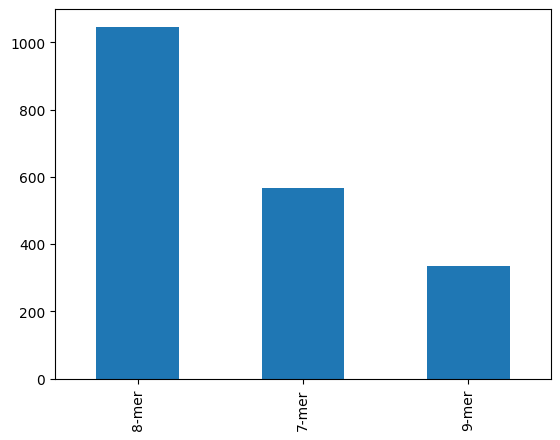

In [4]:
no_of_matches = len(df_mk2[df_mk2["found"] == 1])

print(f"the length of CLASH data is {len(df_mk2)}")
print(f"the number of matches is {no_of_matches}")
print(f"the number of non-matches is {len(df_mk2) - no_of_matches}")
print(f"we found only {no_of_matches / len(df_mk2) * 100} % of the matches")
print("\n")
print("Figure: the seed type distribution of found matches")
df_mk2[df_mk2["found"] == 1].seed_type.value_counts().plot(kind="bar")

## notes

CLASH anchor 1'e bizim gibi bakmıyor. String match ediyor. Bende 7mer-m8 olanlar orada 8mer olduğu gözlendi.

# find matches mk3

added simple_matching switch which uses the logic derived from first experiment

simple_matching?
- modifies anchor_a so it checks for match in that position, instead of checking for actual A
- concats two 7mer types (A1, m8) into a single "7-mer" feature

In [5]:
def find_matches_modded(clash_df, simple_matching=False):

    # creating revcomp mirna sequences
    clash_df["mirna_sequence"] = clash_df["miRNA_seq"].apply(
        reverse_complement)

    # generating seeds
    clash_df["seed"] = clash_df["mirna_sequence"].apply(lambda x: x[-7:-1])

    mrna_seqs = clash_df["mRNA_seq_extended"].tolist()
    seeds = clash_df["seed"].tolist()
    mirna_seqs = clash_df["mirna_sequence"].tolist()

    match_types = []
    start_coords = []
    end_coords = []

    for c in range(len(mrna_seqs)):

        seed = seeds[c]
        mrna_seq = mrna_seqs[c]
        mirna_seq = mirna_seqs[c]

        if seed in mrna_seq:

            # start & end are pythonic indices, started from 0
            start = mrna_seq.index(seed)
            end = start + 6

            m8 = mrna_seq[start-1]
            m8_match = m8 == mirna_seq[-8]

            if simple_matching:
                with contextlib.suppress(IndexError):
                    anchor_a = mrna_seq[end] == mirna_seq[-1]
            
            else:
                with contextlib.suppress(IndexError):
                    anchor_a = mrna_seq[end] == "A"
                
            if anchor_a and m8_match:
                match_types.append("8-mer")
                start_coords.append(start)
                end_coords.append(end+2)

            elif anchor_a:
                
                if simple_matching:
                    match_types.append("7-mer")
                else:
                    match_types.append("7mer-A1")
                start_coords.append(start+1)
                end_coords.append(end+2)

            elif m8_match:
                
                if simple_matching:
                    match_types.append("7-mer")
                
                else:
                    match_types.append("7mer-m8")
                start_coords.append(start)
                end_coords.append(end+1)

            else:
                match_types.append("6-mer")
                start_coords.append(start+1)
                end_coords.append(end+1)

        
        else:
            match_types.append("no_match")
            start_coords.append(None)
            end_coords.append(None)

    clash_df["match_type"] = match_types
    clash_df["start_coord"] = start_coords
    clash_df["end_coord"] = end_coords
    

    
    return clash_df

In [6]:
df_mk3 = find_matches_modded(clash_df, simple_matching=True)

In [7]:
df_mk3.head()

,miRNA_seq,mRNA_start,mRNA_end_extended,mRNA_seq_extended,seed_type,mirna_accession,mirna_name,mrna_enst_id,mrna_ensg_id,mrna_name,found_in_ensembl,seed,found,mirna_sequence,match_type,start_coord,end_coord
0,TGAGGTAGTAGGTTGTATAGTT,1791,1890,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,noncanonical_seed,MIMAT0000062,let-7a,ENST00000340828,ENSG00000113328,CCNG1,1,TACCTC,0,AACTATACAACCTACTACCTCA,no_match,NaN,NaN
1,TGAGGTAGTAGGTTGTATAGTT,3857,3928,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,9-mer,MIMAT0000062,let-7a,ENST00000343455,ENSG00000100697,DICER1,1,TACCTC,1,AACTATACAACCTACTACCTCA,8-mer,23.0,31.0
2,TGAGGTAGTAGGTTGTATAGTT,2385,2434,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,noncanonical_seed,MIMAT0000062,let-7a,ENST00000436639,ENSG00000080546,SESN1,1,TACCTC,0,AACTATACAACCTACTACCTCA,no_match,NaN,NaN
3,TGAGGTAGTAGGTTGTATAGTT,6570,6623,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,noncanonical_seed,MIMAT0000062,let-7a,ENST00000282516,ENSG00000164190,NIPBL,1,TACCTC,0,AACTATACAACCTACTACCTCA,no_match,NaN,NaN
4,TGAGGTAGTAGGTTGTATAGTT,1164,1208,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,noncanonical_seed,MIMAT0000062,let-7a,ENST00000340139,ENSG00000138785,INTS12,1,TACCTC,0,AACTATACAACCTACTACCTCA,no_match,NaN,NaN


In [20]:
df_mk3[df_mk3["found"] == 1]

,miRNA_seq,mRNA_start,mRNA_end_extended,mRNA_seq_extended,seed_type,mirna_accession,mirna_name,mrna_enst_id,mrna_ensg_id,mrna_name,found_in_ensembl,seed,found,mirna_sequence,match_type,start_coord,end_coord
1,TGAGGTAGTAGGTTGTATAGTT,3857,3928,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,9-mer,MIMAT0000062,let-7a,ENST00000343455,ENSG00000100697,DICER1,1,TACCTC,1,AACTATACAACCTACTACCTCA,8-mer,23.0,31.0
5,TGAGGTAGTAGGTTGTATAGTT,4616,4663,AATACTTTCTACTACCTCAGTTTACTTGAGTACTACATTATAGTTTAT,9-mer,MIMAT0000062,let-7a,ENST00000307968,ENSG00000217128,FNIP1,1,TACCTC,1,AACTATACAACCTACTACCTCA,8-mer,12.0,20.0
7,TGAGGTAGTAGGTTGTATAGTT,862,919,ACTTTCTGCGCTTCGACCACTACCTCAACCCCTACTATAAGTTCAT...,9-mer,MIMAT0000062,let-7a,ENST00000261674,ENSG00000061936,SFRS8,1,TACCTC,1,AACTATACAACCTACTACCTCA,8-mer,20.0,28.0
11,TGAGGTAGTAGGTTGTATAGTT,148,201,GGTGGCTCACGCCTACTACCTCAAACACCAGTTCTACCCCACTGTG...,9-mer,MIMAT0000062,let-7a,ENST00000294256,ENSG00000162298,SYVN1,1,TACCTC,1,AACTATACAACCTACTACCTCA,8-mer,16.0,24.0
12,TGAGGTAGTAGGTTGTATAGTT,871,927,ACTGAACATGTACAAGGCCTTGCTACCTCAGCAGTCCTACAGCTTG...,8-mer,MIMAT0000062,let-7a,ENST00000397354,ENSG00000183337,BCOR,1,TACCTC,1,AACTATACAACCTACTACCTCA,8-mer,23.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18461,AGCGCGGGCTGAGCGCTGCCAGTC,90,133,GCCAAGGCCAAGTCGCGCTCGTCCCGCGCTGGCCTTCAGTTCCC,8-mer,MIMAT0017352,miR-2277-5p,ENST00000369161,ENSG00000183558,HIST2H2AA3,1,CCGCGC,1,GACTGGCAGCGCTCAGCCCGCGCT,8-mer,23.0,31.0
18462,CCTCCGTGTTACCTGTCCTCTAG,217,268,GACGATGAGGTGACAGTCACGGAGGATAAGATCAATGCCCTCATTA...,8-mer,MIMAT0017982,miR-3605-3p,ENST00000260379,ENSG00000137818,RPLP1,1,ACGGAG,1,CTAGAGGACAGGTAACACGGAGG,8-mer,18.0,26.0
18474,TCAGCAGGCAGGCTGGTGCAGC,176,233,CCGAAGGCTGCTTCTGCTGCCGCTACTGCTGTTCCTGCTGCCGGCT...,7-mer,MIMAT0017999,miR-3619,ENST00000379341,ENSG00000123131,PRDX4,1,CTGCTG,1,GCTGCACCAGCCTGCCTGCTGA,6-mer,14.0,20.0
18485,CCGTGTTTCCCCCACGCTTT,2114,2166,GACAGCAGCCACGTGGGCAAACACGAGTATTTCATGCATGCCACAG...,7-mer,MIMAT0018100,miR-3676,ENST00000308775,ENSG00000173402,DAG1,1,AACACG,1,AAAGCGTGGGGGAAACACGG,7-mer,19.0,26.0


# expanding results

added new logic to check the matches.

ex: if we found 8-mer and CLASH has 9-mer in that place, I counted it as a match here.

In [16]:
small_df = df_mk3.copy()
small_df = clash_df[["seed_type", "match_type"]]


matches = []

for i, row in small_df.iterrows():
    
    if row.seed_type == row.match_type:
        matches.append("found")
    
    elif row.seed_type == "9-mer" and row.match_type == "8-mer":
        matches.append("9mer found as 8mer")
    
    elif row.seed_type == "8-mer" and row.match_type == "7-mer":
        matches.append("8mer found as 7mer")

    elif row.seed_type == "8-mer" and row.match_type == "6-mer":
        matches.append("8mer found as 6mer")

    elif row.seed_type == "noncanonical_seed" and row.match_type == "no_match":
        matches.append("noncanonical as not found")
    
    elif row.seed_type == "noseed_9nt_stem" and row.match_type == "no_match":
        matches.append("no seed, 9nt match as not found")
    
    elif row.seed_type == "none" and row.match_type == "no_match":
        matches.append("no seed match as not found")

    else:
        matches.append("everything else")
        
small_df["matches"] = matches


# appending to dicts
value_dict = small_df["matches"].value_counts().to_dict()

percentage_dict = small_df["matches"].value_counts().to_dict()

for key in percentage_dict:
    percentage_dict[key] = round(percentage_dict[key] / len(small_df) * 100, 2)

/tmp/ipykernel_4986/2296869711.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df["matches"] = matches


noncanonical as not found          7137
no seed match as not found         4084
no seed, 9nt match as not found    3151
found                              1789
everything else                    1342
8mer found as 7mer                  676
9mer found as 8mer                  329
8mer found as 6mer                    6
Name: matches, dtype: int64

results above, visualized in a table

| Data                               | Count | Percentages                       |
|------------------------------------|-------|----------------------------------|
| noncanonical as not found          | 7137  | 38.55                            |
| no seed match as not found         | 4084  | 22.06                            |
| no seed, 9nt match as not found    | 3151  | 17.02                            |
| found                              | 1789  | 9.66                             |
| everything else                    | 1342  | 7.25                             |
| 8mer found as 7mer                 | 676   | 3.65                             |
| 9mer found as 8mer                 | 329   | 1.78                             |
| 8mer found as 6mer                 | 6     | 0.03   


In [25]:
def preprocess_clash_data(data="../data/supplementary_files/clash_data_parsed.tsv", drop_irrelevant_columns=True):
    """
    Preprocess the parsed CLASH data and return a df
    """
    clash_df = pd.read_csv(data, sep="\t", header=2)

    if drop_irrelevant_columns:
        columns_to_keep = ["microRNA_name", "miRNA_seq", "mRNA_name", "mRNA_start", "mRNA_end_extended", "mRNA_seq_extended", "seed_type", "folding_class"]
        clash_df = clash_df[columns_to_keep]
    # unzipping columns
    mirnas = clash_df["microRNA_name"].tolist()
    mirna_accessions = []
    mirna_names = []

    for i in mirnas:
        temp = i.split("_")
        mirna_accessions.append(temp[0])
        mirna_names.append(temp[2])

    clash_df["mirna_accession"] = mirna_accessions
    clash_df["mirna_name"] = mirna_names
    clash_df.drop(["microRNA_name"], axis=1, inplace=True)

    # --------------------------------------------------
    mrnas = clash_df["mRNA_name"].values.tolist()
    mrna_ensg_ids = []
    mrna_enst_ids = []
    mrna_names = []

    for i in mrnas:
        temp = i.split("_")
        mrna_ensg_ids.append(temp[0])
        mrna_enst_ids.append(temp[1])
        mrna_names.append(temp[2])

    clash_df["mrna_enst_id"] = mrna_enst_ids
    clash_df["mrna_ensg_id"] = mrna_ensg_ids
    clash_df["mrna_name"] = mrna_names
    clash_df.drop(["mRNA_name"], axis=1, inplace=True)

    return clash_df

In [26]:
clash_df = preprocess_clash_data()

clash_df.head()

,miRNA_seq,mRNA_start,mRNA_end_extended,mRNA_seq_extended,seed_type,folding_class,mirna_accession,mirna_name,mrna_enst_id,mrna_ensg_id,mrna_name
0,TGAGGTAGTAGGTTGTATAGTT,1791,1890,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,noncanonical_seed,III,MIMAT0000062,let-7a,ENST00000340828,ENSG00000113328,CCNG1
1,TGAGGTAGTAGGTTGTATAGTT,3857,3928,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,9-mer,II,MIMAT0000062,let-7a,ENST00000343455,ENSG00000100697,DICER1
2,TGAGGTAGTAGGTTGTATAGTT,2385,2434,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,noncanonical_seed,III,MIMAT0000062,let-7a,ENST00000436639,ENSG00000080546,SESN1
3,TGAGGTAGTAGGTTGTATAGTT,6570,6623,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,noncanonical_seed,III,MIMAT0000062,let-7a,ENST00000282516,ENSG00000164190,NIPBL
4,TGAGGTAGTAGGTTGTATAGTT,1164,1208,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,noncanonical_seed,III,MIMAT0000062,let-7a,ENST00000340139,ENSG00000138785,INTS12


In [28]:
clash_df[clash_df["folding_class"] == "V"]

,miRNA_seq,mRNA_start,mRNA_end_extended,mRNA_seq_extended,seed_type,folding_class,mirna_accession,mirna_name,mrna_enst_id,mrna_ensg_id,mrna_name
185,TGAGGTAGTAGGTTGTATAGTT,450,501,AATGATGGGCCCTCCTCCTCCTGGGATGATGCCAGTGGGACCTGCT...,noncanonical_seed,V,MIMAT0000062,let-7a,ENST00000244520,ENSG00000124562,SNRPC
190,TGAGGTAGTAGGTTGTATAGTT,981,1032,CATGACCCAACCTACCACCCTGTTTTTACATATCCAATTCCAGTAA...,none,V,MIMAT0000062,let-7a,ENST00000380629,ENSG00000104765,BNIP3L
191,TGAGGTAGTAGGTTGTATAGTT,1260,1309,CTTCAAGCCAGCCTACAACCCATACACAGAGCCCAGCATGGAGGTG...,none,V,MIMAT0000062,let-7a,ENST00000314606,ENSG00000179115,FARSA
210,TGAGGTAGTAGGTTGTATAGTT,2446,2492,ACCTCACCACTCTACCTCAGATATCATTTGCTTTTCCAGTCAGCGAT,8-mer,V,MIMAT0000062,let-7a,ENST00000394522,ENSG00000145349,CAMK2D
212,TGAGGTAGTAGGTTGTATAGTT,10054,10107,TTTCTACCACTAAAGTGTTCCCTGCTACCATCCTGGCTTGTCCACA...,noncanonical_seed,V,MIMAT0000062,let-7a,ENST00000265734,ENSG00000105810,CDK6
...,...,...,...,...,...,...,...,...,...,...,...
18493,CCCGGACAGGCGTTCGTGCGACGT,6359,6401,GACTTGCGGCCCCGGGTTGGGAGGAAAACCCGTTCCGGAGCCG,noncanonical_seed,V,MIMAT0018115,miR-3687,ENST00000353383,ENSG00000108557,RAI1
18494,CCCGGACAGGCGTTCGTGCGACGT,4180,4229,AGTGCGCCCCATCCCAGGGAGGGTTCCTTGGGGACAAGGGTGGTTG...,none,V,MIMAT0018115,miR-3687,ENST00000299505,ENSG00000166398,KIAA0355
18495,CCCGGACAGGCGTTCGTGCGACGT,817,859,CCTCTCCCCGGGACTCCCTAGCTCTGGGCAGGGCAGACCCCGG,noncanonical_seed,V,MIMAT0018115,miR-3687,ENST00000309241,ENSG00000155846,PPARGC1B
18496,AGTGGATGATGGAGACTCGGTAC,3519,3561,TTCTCCCTCTCCACCATTGCCGAGGGCTCTCACCCAAATGATG,noncanonical_seed,V,MIMAT0018120,miR-3691,ENST00000264723,ENSG00000114646,CSPG5


In [29]:
clash_df["folding_class"].unique()

array(['III', 'II', 'I', 'V', 'IV'], dtype=object)